# Pattern Recognition 1 - Expert System

**Objectives**

* Create a working image analysis and pattern recognition pipeline
* Object labelisation and feature extraction
* Creating an Expert System for Optical Character Recognition (OCR)

**Libraries needed for this lab**

* Numpy
* Matplotlib
* Scikit-image

(all included in the Anaconda distribution)

Idée des labs : on reçoit une image et on utilise technique pour les analyses

et idée est de créer OCR : image d'un texte et on veut automatiquement lire le texte et donc on a un string à la fin qui contient les caractères

au début : on va lire les lettres et les classifier et voir comment on peut extraire les infos importantes qu'on aura beosin pour faire la classification

idée : séparer les lettres du background, séparer les différentes lettres, trouver leur position, l'ordre, ... et en gros avoir des règles pour savoir quelle lettre correspond à quel caractère. bref on veut lire le texte. mais donc c'est low level les4 premiers tps, sans machine learning et apèrs on se focusera sur classification avec ML.

## Object detection

Given the following image :

(851, 1068) uint8


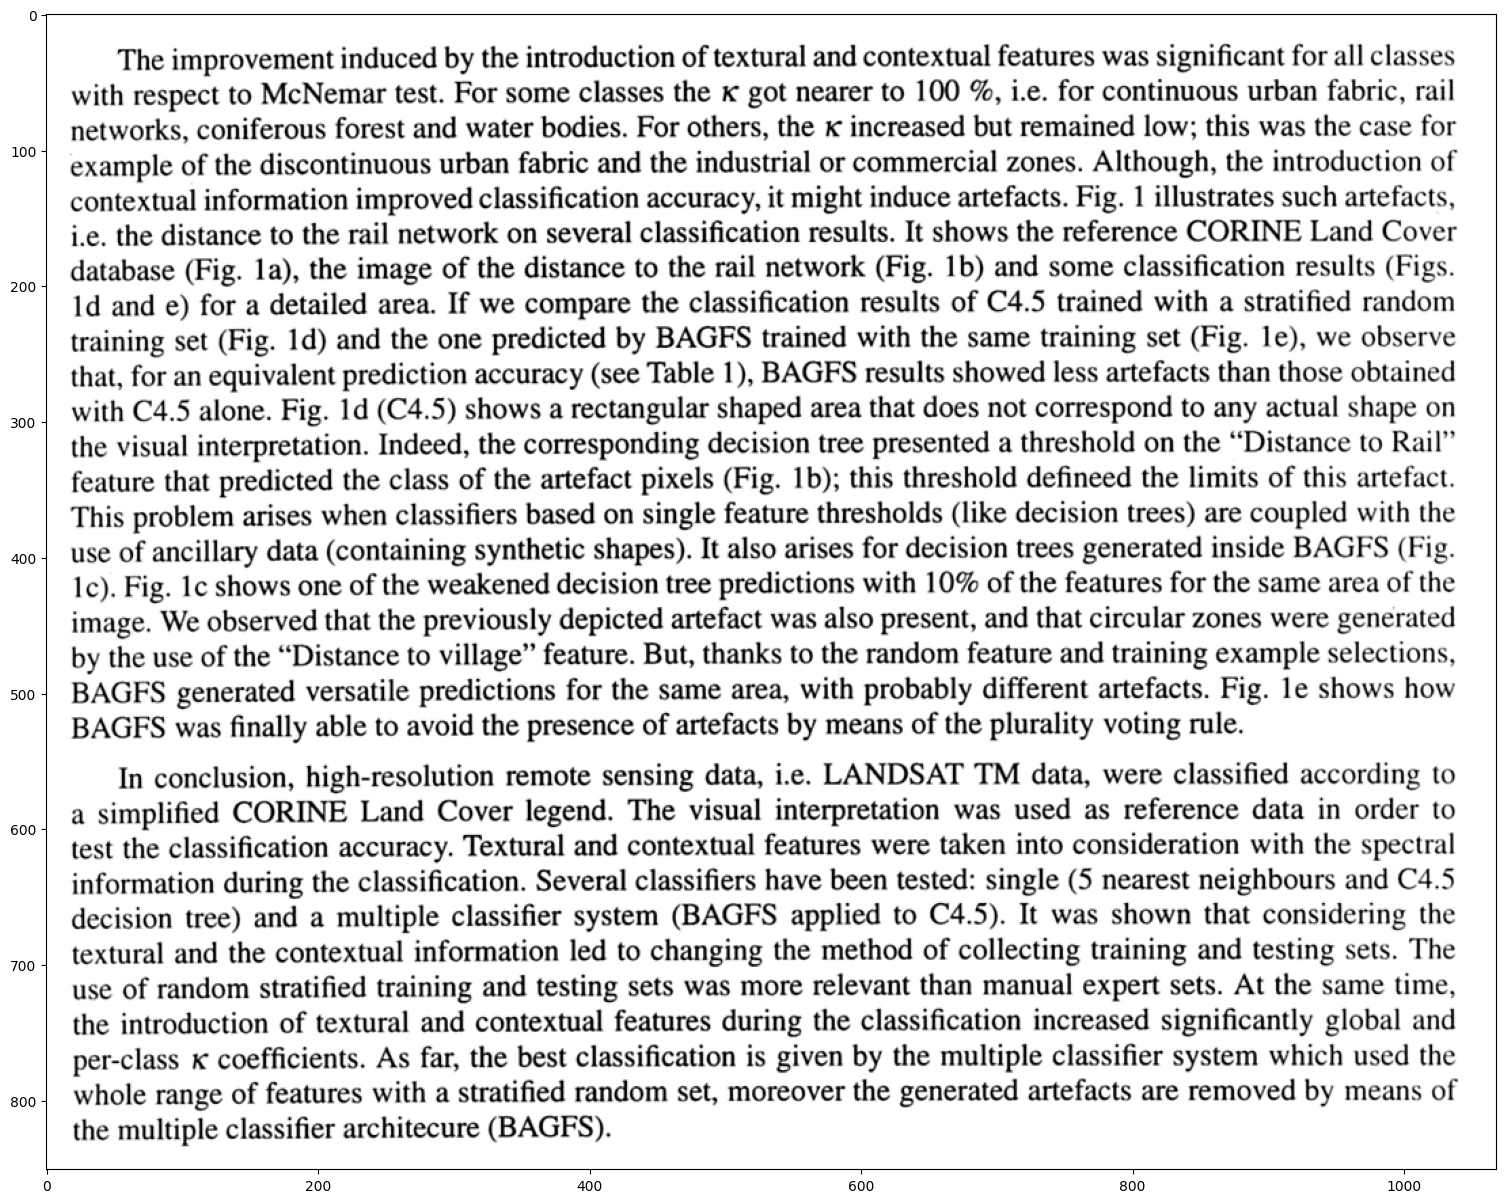

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
%matplotlib inline

im = imread('../data/doc1.png')
print(im.shape, im.dtype)

plt.figure(figsize=(20,15))
plt.imshow(im, cmap=plt.cm.gray)
plt.show()

* **Segment** the image to isolate the text from the background
* **Label individual characters** and **extract** the centroid position, the bounding box, and useful features for each character.

Useful documentation: [`skimage.measure`](http://scikit-image.org/docs/dev/api/skimage.measure.html) module.

0 255


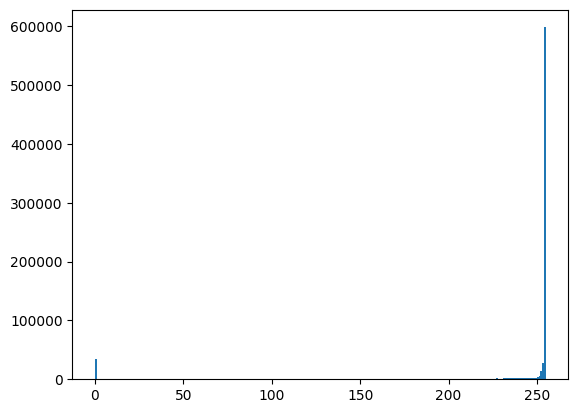

In [4]:

## -- Your code here -- ##

#separate letters from the background (binary segmentation problem), donc character class et background.

print(im.min(), im.max())
plt.hist(im.flatten(), bins = 255)
plt.show() # on voit que c'est assez facile à séparer les 2 ici

#Algo pour segmenter auto : otsu, ... mais pas très interessant ici, pcq flat entre les 2 pics, donc dur de savoir si on coupe à 100, 150, ... donc mieux de faire manuelleent



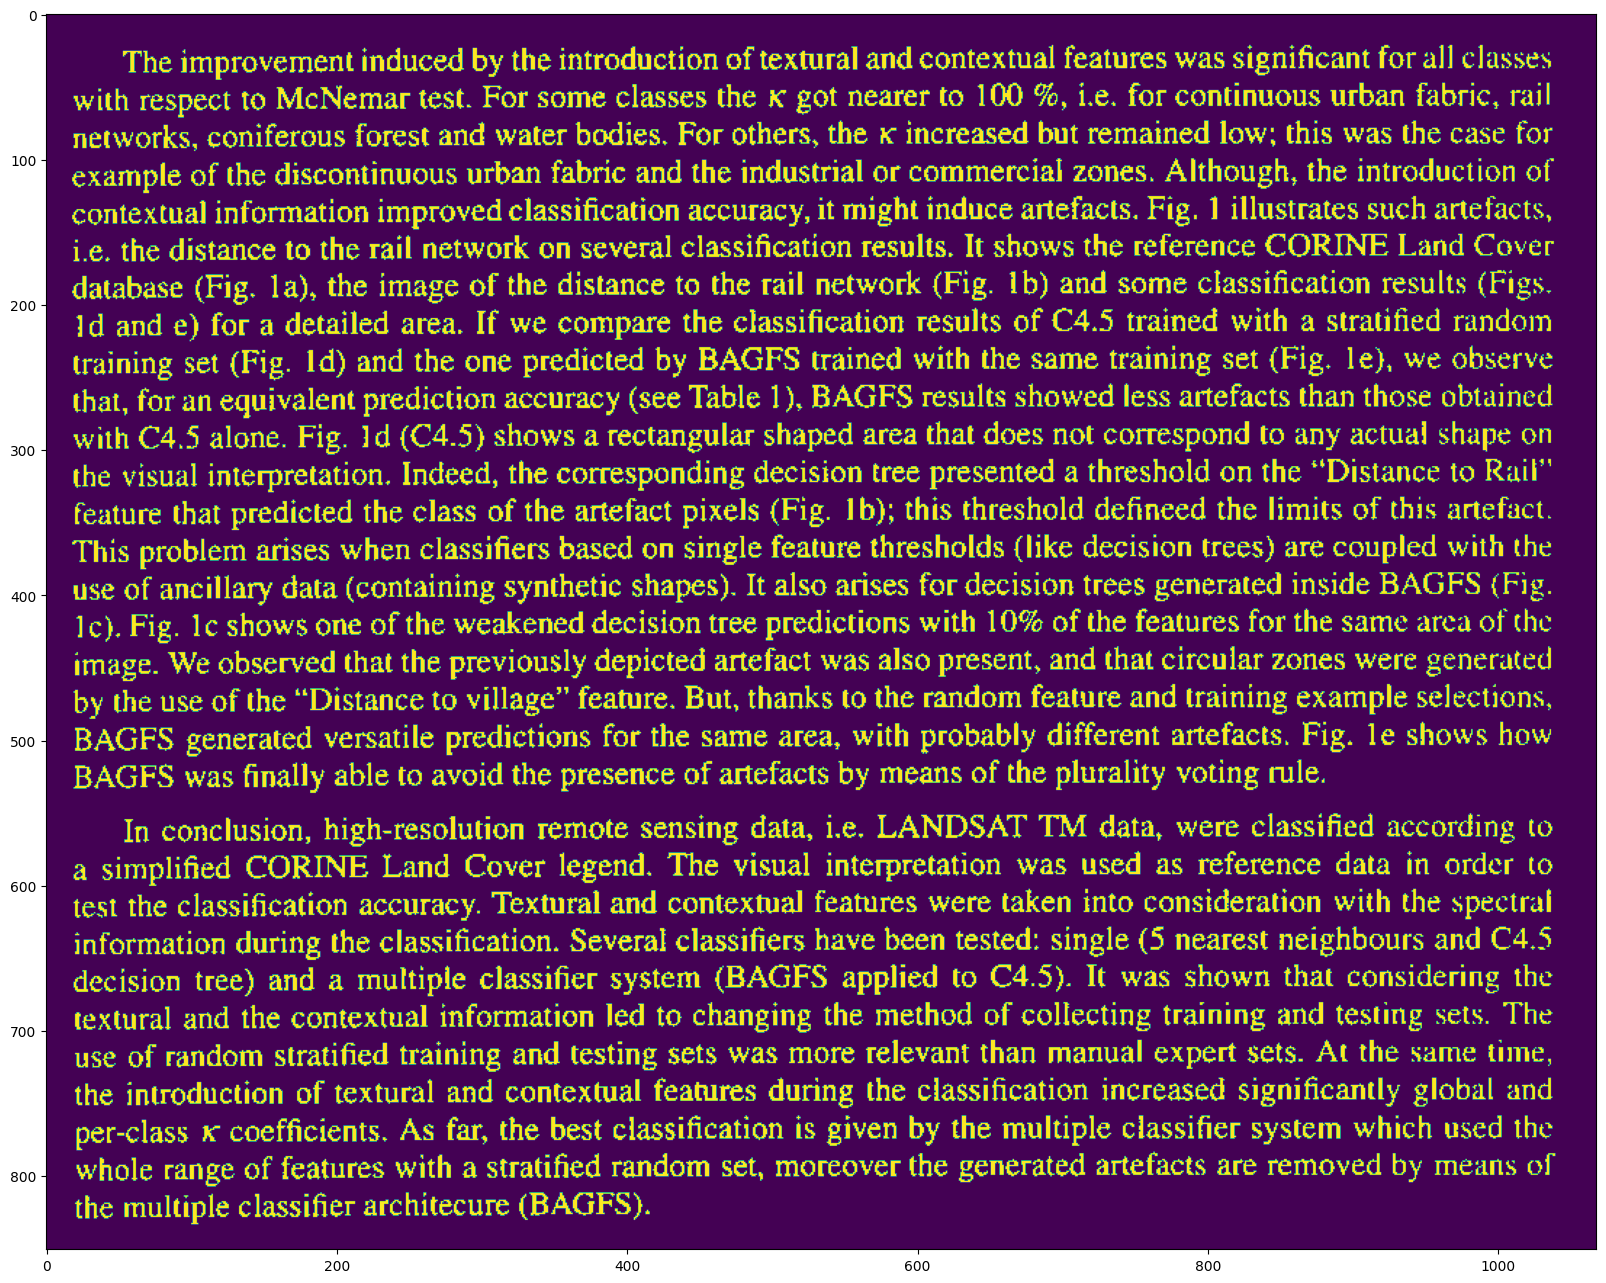

In [9]:
segmented = im < 150 # avec 127, les s sont pas très bien coupés. on check sur chacun des pixels et on get un array true false sur le pixel d'interet
plt.figure(figsize=(20,20))
plt.imshow(segmented)
plt.show()

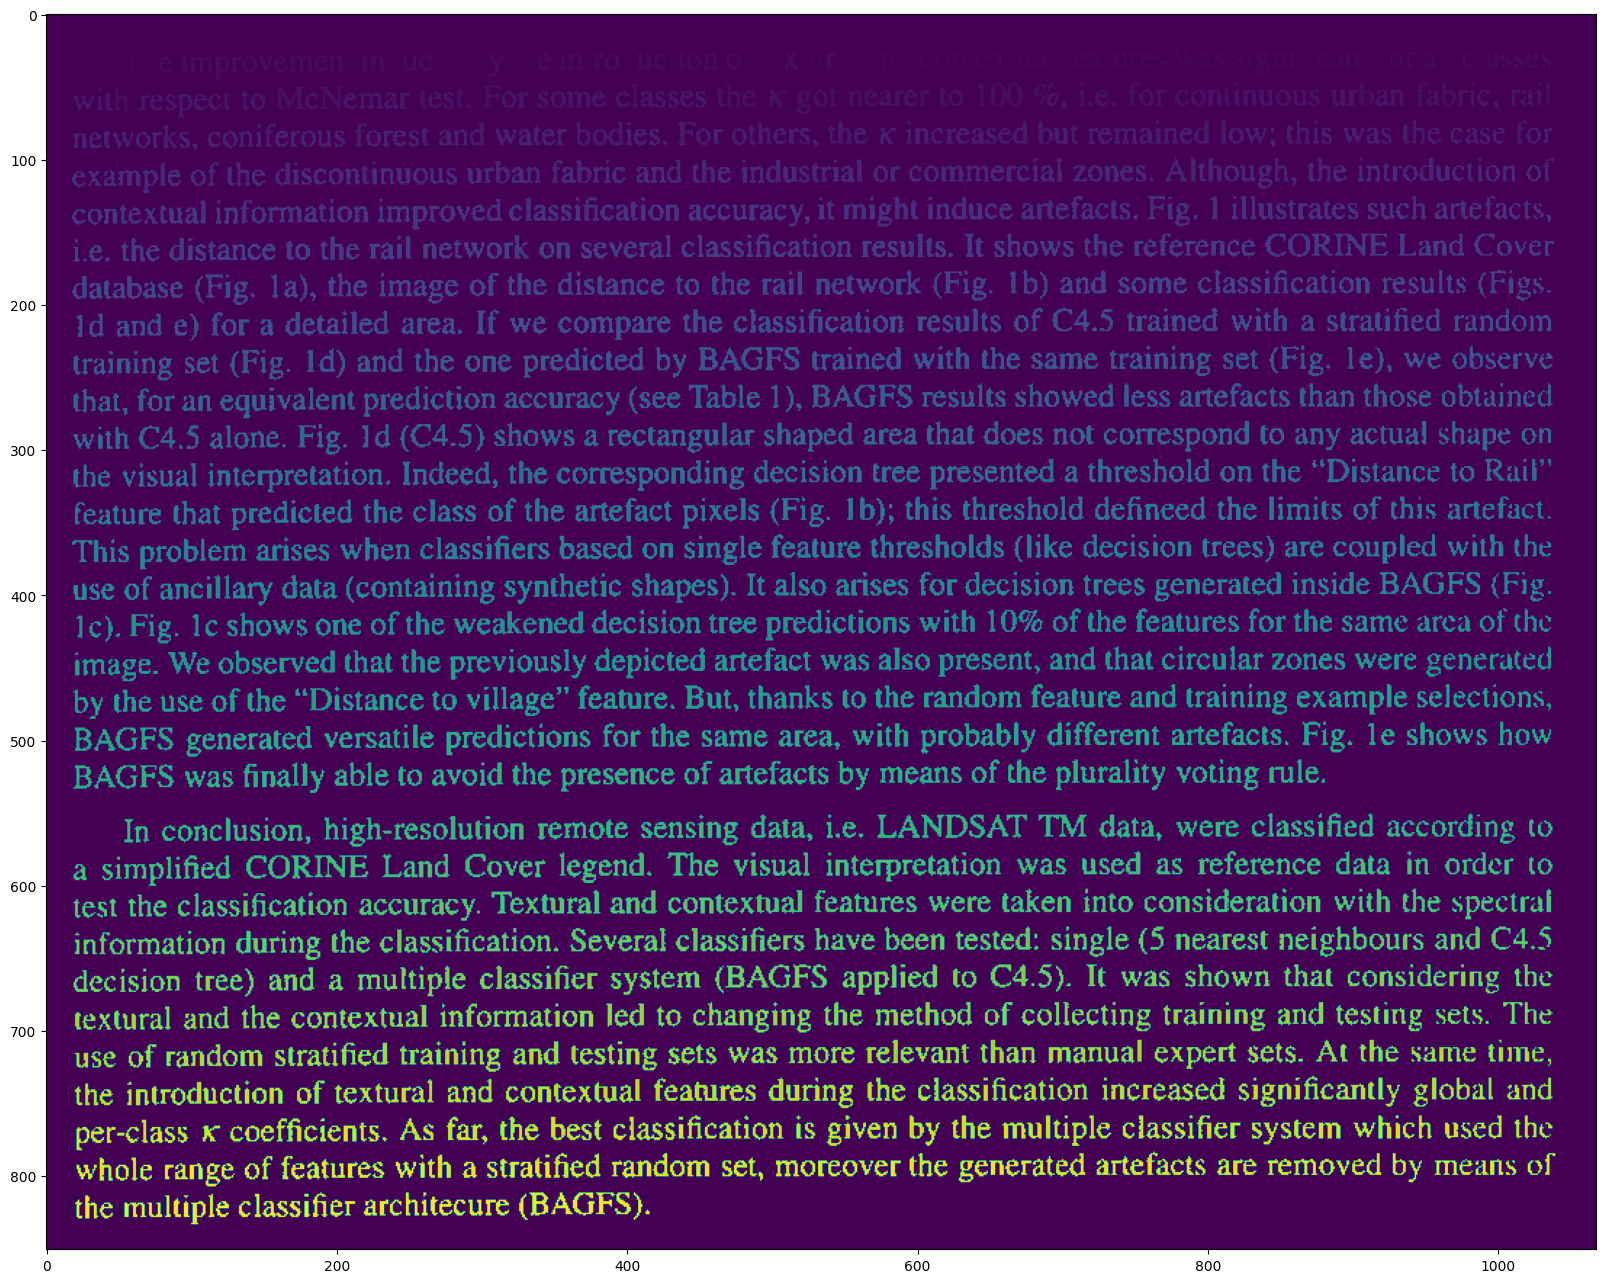

In [13]:
# Mais ici on a que séparation binaire, on veut faire instance segmentation, càd séparer chaque instance
# et idée est de dire : si les objets sont connectés, même objet 
# et pour ça on utilise skimage (voir documentation ou vidéo) : mais la connectivité peut être différente par exemple considiérer les diagonales ou pas, ... (1-conenctivity, 2 connectivty)
#Mais risque de 1 conencitvity par exemple c'est que some letters vont être connectés ensemble ou bien une lettre sera séparé en plusieurs. 
#Mais donc regarder image et choisir

from skimage.measure import label

label_image = label(segmented) # on donne un label à chaque instance, et donc les instances qui ont la même valeur sont les mêmes objets.
#pb par contre pour les i avec le point au dessus

# si on zoom sur un with : on voit que le h sera plus foncé que le w (logique) mais du coup pas fiable pour donner l'ordre 
plt.figure(figsize=(20,20))
plt.imshow(label_image) # on voit que label donné de top to bottom et de guache à droite. et higher label en bas de la page.
plt.show()

In [16]:
# Maintenant si on veut trouver l'ordre : on extrait info à propos de la position de chaque instance/caractère.
#pour ça on va regarder centroides ; les objets proches devraient avoir centroide close

from skimage.measure import regionprops # regionprops donne plein d'infos/features sur chaque label qui sera important pour ordre et aussi séparer les caractères vu qu'ils auront des stats diff
# mais d'abord classification, faut donner le bon ordre

objects_properties = regionprops(label_image)

for obj in objects_properties:
    print(obj['centroid'], obj['bbox']) # centroid et rectangle de leur bounding box (starting row, end row, starting col and end col)
    break

# Mainteant il faut utiliser ces infos pour determiner pour chaque lettre à quelle line il appartient, donc en gros mettre les lettres de la même ligne sur une ligne

(30.142857142857142, 692.5142857142857) (22, 691, 38, 695)



## Line detection and letter ordering

* Find the labels (objects) that belong to each text line
* Order each character in a text line from left to right

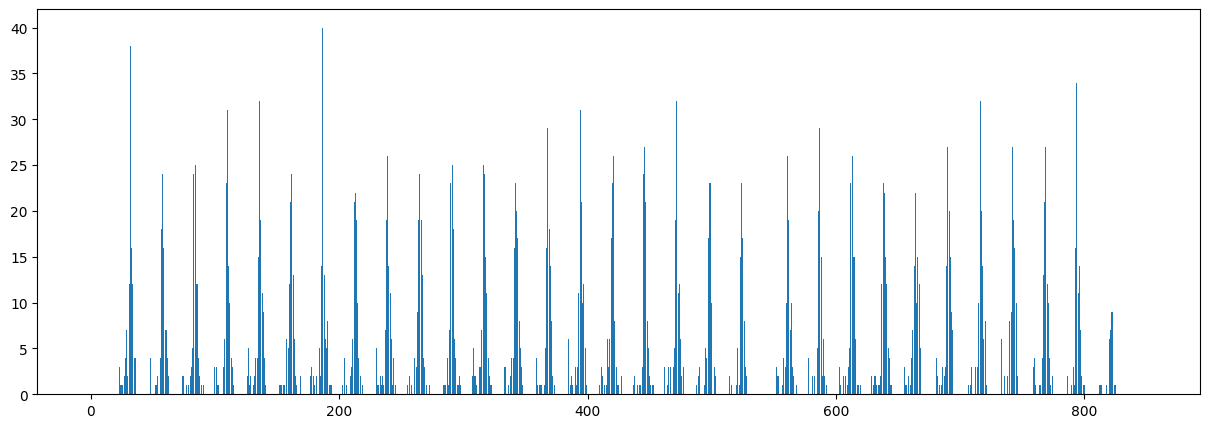

In [17]:
# Mainteant il faut utiliser ces infos pour determiner pour chaque lettre à quelle line il appartient, donc en gros mettre les lettres de la même ligne sur une ligne
# Et pour ça, on peut utiliser centroid ou bounding box
# donc on veut regrouper les lettres en fct de la ligne à laquelle elles appartiennent
centroid_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    centroid_ys[int(obj['centroid'][0])] += 1 # en gros ça donne un histo me dit pour chaque ligne, combien d'ojets j'ai où le centroid est à cette position

plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), centroid_ys)
plt.show()

In [ ]:
# Pb discontuinité  ! réecouter si jamais vers 35min
# lignes pas tout à fait horizontal : end surement plus haut que le début d'une ligne
# et d'autres trucs

# donc ce qu'on peut faire : si area en dessous d'un certain seuil, we don't count it ! (genre enlelver les points des i)

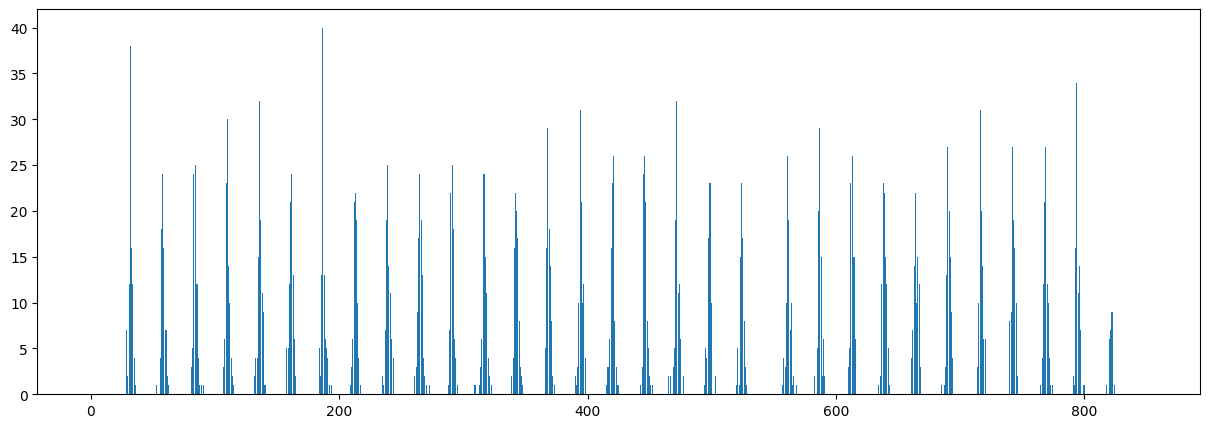

In [21]:
centroid_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    if obj.area < 10 : # filter smaller than 10 pixels, donc on enleve les artefeact
        continue
    centroid_ys[int(obj['centroid'][0])] += 1 
plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), centroid_ys)
plt.show()

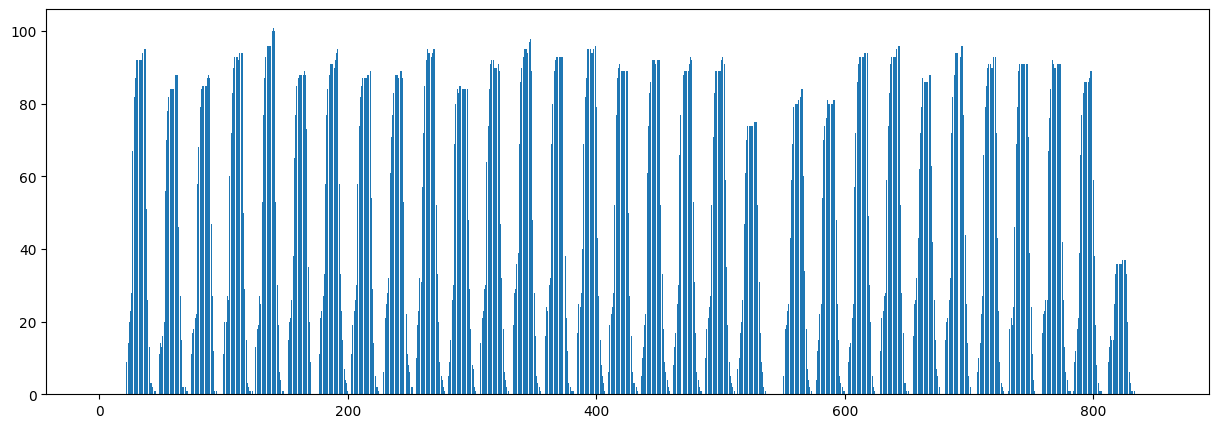

In [19]:
bbox_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    bbox_ys[obj["bbox"][0]:obj['bbox'][2]] += 1 

plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), bbox_ys)
plt.show()

#Et pour trouver les lignes (rows), on peut prendre les max de chaque mini stribution, et ça serati bon guess pour trouver les lignes du texte
#et donc on peut trouver la position de chaque pic, et assigner à chaque objet, asigner un pic et dire que l'objet appartient à cette ligne
#on pourrait aussi se dire : dès que j'ai pas de centroid pdt 4 valeurs, je peux cut et me dire ce qu'il y avait avant fait partie d'une ligne

In [ ]:
# aussi assez discontinue entre chaque pic

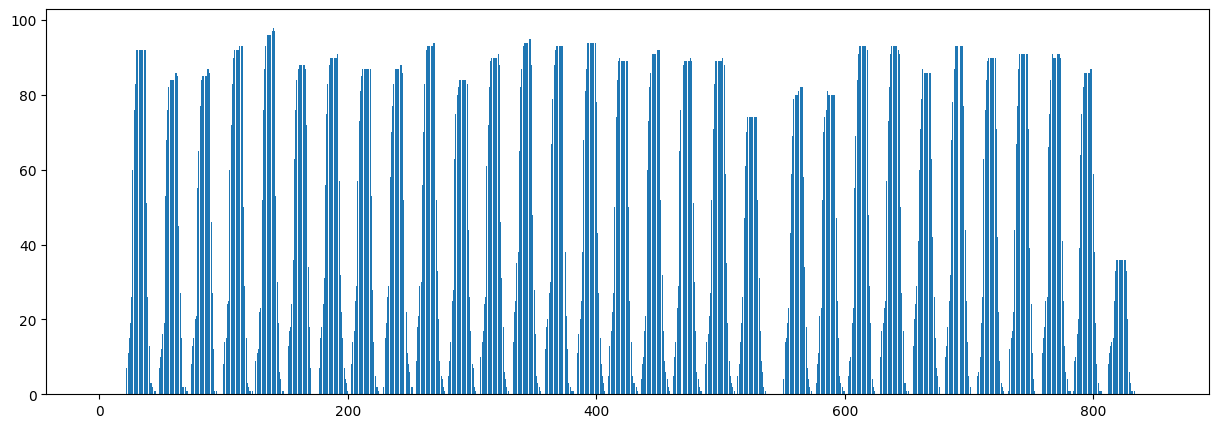

In [22]:
bbox_ys = np.zeros((im.shape[0])) # nombre de lignes

for obj in objects_properties:
    if obj.area < 10 : # filter smaller than 10 pixels, donc on enleve les artefeact
        continue
    bbox_ys[obj["bbox"][0]:obj['bbox'][2]] += 1 

plt.figure(figsize=(15, 5))
plt.bar(range(im.shape[0]), bbox_ys)
plt.show()



In [ ]:
# Solution proposée avec centroid approach (voir vidéo à genre 45min)

#il donne aussi d'autres méthodes

# Il a dit ausis qu'il y avait une méthode peak local max de skimmage pour chooper les mins/max



## Expert System classification

* Using the features available with the [regionprops](http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops) method of scikit-image, propose a method to automatically recognize some letters.

In [ ]:

## -- Your code here -- ##


## Full OCR pipeline

Using all the previous exercices, create a method that takes as input a text image, and outputs the recognized text.

In [ ]:
def OCR(im):
    text = ''
    
    return text

print(OCR(im))

In [ ]:
#problème de cette méthode : il faut trouver des ègles pour chaque lettre qui les distingue, mais pb c'est que ça prend du temps
#et aussi que ces règles ne sont pa très unvierselles entre différents textes, ... (fond, police différente, ...)

#ML sera bcp plus robuste

